# Predicting the flow of the South Fork Payette River using machine learning


Import USGS streamflow data and NOAA climate data

In [753]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

In [754]:
df = pd.read_csv("/content/payette_streamflow.txt", sep='\t', header=None)

In [755]:
payette_df = df.drop(columns=[0,1, 4,5,6,7,8,9,10])

In [756]:
features_df = pd.read_csv("/content/climate_data_payette.csv", error_bad_lines=False)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (7,23) have mixed types.Specify dtype option on import or set low_memory=False.



Let's just use the Banner Summit station for simplicity's sake.

## Exploring and cleaning the data.

In [757]:
banner_df = features_df[features_df['NAME']=='BANNER SUMMIT, ID US']

In [758]:
banner_df.isnull().sum()

STATION                0
NAME                   0
LATITUDE               0
LONGITUDE              0
ELEVATION              0
DATE                   0
AWND               12295
AWND_ATTRIBUTES    12295
PRCP                   2
PRCP_ATTRIBUTES        2
SNWD                5139
SNWD_ATTRIBUTES     5139
TAVG                 527
TAVG_ATTRIBUTES      527
TMAX                 526
TMAX_ATTRIBUTES      526
TMIN                 535
TMIN_ATTRIBUTES      535
TOBS                  75
TOBS_ATTRIBUTES       75
WESD                   4
WESD_ATTRIBUTES        4
WSFI               12295
WSFI_ATTRIBUTES    12295
dtype: int64

In [759]:
banner_df.shape

(12295, 24)

In [760]:
banner_df.columns

Index(['STATION', 'NAME', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'DATE', 'AWND',
       'AWND_ATTRIBUTES', 'PRCP', 'PRCP_ATTRIBUTES', 'SNWD', 'SNWD_ATTRIBUTES',
       'TAVG', 'TAVG_ATTRIBUTES', 'TMAX', 'TMAX_ATTRIBUTES', 'TMIN',
       'TMIN_ATTRIBUTES', 'TOBS', 'TOBS_ATTRIBUTES', 'WESD', 'WESD_ATTRIBUTES',
       'WSFI', 'WSFI_ATTRIBUTES'],
      dtype='object')

In [761]:
null_columns = ['AWND', 'AWND_ATTRIBUTES', 'WSFI', 'WSFI_ATTRIBUTES']

In [762]:
banner_df = banner_df.drop(columns=null_columns)

In [763]:
constant_columns = ['STATION', 'NAME', 'LATITUDE', 'LONGITUDE', 'ELEVATION']

In [764]:
banner_df = banner_df.drop(columns=constant_columns)

In [765]:
payette_df.columns = ['DATE', 'STREAMFLOW']

In [766]:
payette_df

,DATE,STREAMFLOW
0,1987-01-01,272
1,1987-01-02,290
2,1987-01-03,296
3,1987-01-04,291
4,1987-01-05,282
...,...,...
12293,2020-08-28,408
12294,2020-08-29,398
12295,2020-08-30,391
12296,2020-08-31,394


Merging the USGS data and the NOAA data on date.

In [767]:
banner_df = banner_df.merge(payette_df, left_on='DATE', right_on='DATE')


Here we're going to do some feature engineering. I want to get the 'day of year' from the datetime object.

In [768]:
type(banner_df['DATE'][0])

str

In [769]:
banner_df['DATE'] = pd.to_datetime(banner_df['DATE'])

In [770]:
type(banner_df['DATE'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [771]:
banner_df['DAY_OF_YEAR'] = banner_df['DATE'].dt.dayofyear

## Exploratory visualizations

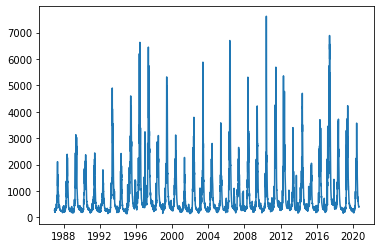

In [772]:
plt.plot(banner_df['DATE'], banner_df['STREAMFLOW']);

In [773]:
px.line(
    banner_df,
    x='DATE',
    y='STREAMFLOW')

In [774]:
px.scatter(
    banner_df,
    x='DAY_OF_YEAR',
    y='STREAMFLOW')

In [775]:
px.scatter(
    banner_df,
    x='PRCP',
    y='STREAMFLOW')

The TAVG, temperature average, looks like it will have some predictive value.

In [776]:
px.scatter(
    banner_df,
    x='TAVG',
    y='STREAMFLOW')

## Simple models

Let's start with the baseline. If we just predicted the mean streamflow, it would be about 800 cfs.

In [777]:
baseline_prediction = banner_df['STREAMFLOW'].mean()
print(baseline_prediction)

799.9204554697031


And let's visualize the results.

In [778]:
baseline_df = banner_df.copy()

In [779]:
baseline_df['BASELINE PREDICTION'] = baseline_prediction

In [780]:

# Plot 
fig = px.line(baseline_df, x='DATE', y='STREAMFLOW')

# Only thing I figured is - I could do this 
fig.add_scatter(x=baseline_df['DATE'], y=baseline_df['BASELINE PREDICTION']) 

# Show plot 
fig.show()

## Linear Regression

Now I'm going to create a simple linear model.

In [781]:
from sklearn.linear_model import LinearRegression

In [782]:
model = LinearRegression()

First, I'll break the data into train and test sets.

We'll train on the years 1987-2015 and test on the years 2016-2020.


In [783]:
train_df = banner_df[banner_df['DATE'].dt.year <= 2015]
test_df = banner_df[banner_df['DATE'].dt.year > 2015]

In [784]:
print(train_df.shape)
print(test_df.shape)

(10592, 17)
(1703, 17)


In [785]:
features = ['DAY_OF_YEAR']
target = 'STREAMFLOW'

In [786]:
x_train = train_df[features]
y_train = train_df[target]
x_test = test_df[features]
y_test = test_df[target]

In [787]:
print(f'Linear Regression, dependent on: {features}')

Linear Regression, dependent on: ['DAY_OF_YEAR']


In [788]:
model.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [789]:
y_pred = model.predict(x_test)

In [790]:
from sklearn.metrics import mean_absolute_error

In [791]:
mae_one_feature = mean_absolute_error(y_test, y_pred)

In [792]:
print(f'MEAN ABSOLUTE ERROR: {mae_one_feature:,.0f} CFS')

MEAN ABSOLUTE ERROR: 685 CFS


When we do a linear regression with one feature, the day of the year, the MAE is 685 cfs.


How does that compare to just guessing the average flow?


In [793]:
mae_baseline = mean_absolute_error(y_test, [baseline_prediction]*len(y_test))

In [794]:
print(f'MEAN ABSOLUTE ERROR: {mae_baseline:,.0f} CFS')

MEAN ABSOLUTE ERROR: 712 CFS


It's slightly better - 27 cfs better on average- but that's still not great. 600 + cfs is a lot to get the flow estimation wrong by, especially because the average flow is 800 cfs!

That would be almost like guessing that the river is empty or twice the current flow, most of the time.

In [795]:
diff_from_baseline = mae_baseline - mae_one_feature
print(f'Model error improvement from baseline: {diff_from_baseline:,.0f} CFS')

Model error improvement from baseline: 27 CFS


Let's also look at the R^2 score


In [796]:
from sklearn.metrics import r2_score

In [797]:
r2_baseline = r2_score(y_test, [baseline_prediction]*len(y_test))
print(r2_baseline)

-0.030307849670689224


In [798]:
r2_one_feature = r2_score(y_test, y_pred)
print(r2_one_feature)

-0.013160718374388036


Let's look visually at what this one-feature linear regression is predicting.

In [799]:
df = pd.DataFrame({'Date':banner_df['DATE'][-len(y_test):], 'Actual CFS':y_test, 'Predicted CFS':y_pred})

fig = go.Figure()
fig.add_trace(go.Scatter(x=df['Date'],y=df['Actual CFS'],
                    mode='lines',
                    name='Actual CFS'))
fig.add_trace(go.Scatter(x=df['Date'],y=df['Predicted CFS'],
                    mode='lines',
                    name='Predicted CFS'))

fig.show()

## Now it's time to add some more features into this model.


## Download a cleaned and merged csv


In [800]:
numeric_features = ['DATE','PRCP','SNWD','TAVG','TMAX','TMIN','TOBS','WESD','DAY_OF_YEAR','STREAMFLOW']

In [801]:
cleaned_banner_df = banner_df[numeric_features]

In [802]:

# from google.colab import files
# cleaned_banner_df.to_csv('cleaned_banner_df.csv')
# files.download('cleaned_banner_df.csv')


I want to use the 'TAVG' or Temperature Average feature, but there are NaNs in it.

In [803]:
banner_df[banner_df['TAVG'].isnull()]

,DATE,PRCP,PRCP_ATTRIBUTES,SNWD,SNWD_ATTRIBUTES,TAVG,TAVG_ATTRIBUTES,TMAX,TMAX_ATTRIBUTES,TMIN,TMIN_ATTRIBUTES,TOBS,TOBS_ATTRIBUTES,WESD,WESD_ATTRIBUTES,STREAMFLOW,DAY_OF_YEAR
0,1987-01-01,0.9,",,T",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0,",,T",6.8,",,T",272,1
1,1987-01-02,0.1,",,T",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.0,",,T",6.8,",,T",290,2
2,1987-01-03,0.4,",,T",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.0,",,T",7.4,",,T",296,3
3,1987-01-04,0.0,",,T",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,",,T",7.4,",,T",291,4
4,1987-01-05,0.0,",,T",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,",,T",7.4,",,T",282,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3839,1997-07-06,0.0,",,T",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,",,T",2570,187
3968,1997-11-12,0.0,",,T",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.1,",,T",402,316
4585,1999-07-22,0.0,",,T",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,",,T",1020,203
4950,2000-07-21,0.0,",,T",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,",,T",557,203


I'm going to have to impute the average value for those 527 observations that are missing TAVG.

In [804]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer()

In [805]:
features = ['DAY_OF_YEAR', 'TAVG']
target = 'STREAMFLOW'

In [806]:
x_train = train_df[features]
y_train = train_df[target]
x_test = test_df[features]
y_test = test_df[target]

In [807]:
print(f'Linear Regression, dependent on: {features}')

Linear Regression, dependent on: ['DAY_OF_YEAR', 'TAVG']


In [808]:
x_train = imputer.fit_transform(x_train)

In [809]:
model.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [810]:
y_pred = model.predict(x_test)

In [811]:
mae_two_features = mean_absolute_error(y_test, y_pred)

In [812]:
print(f'MEAN ABSOLUTE ERROR: {mae_two_features:,.0f} CFS')

MEAN ABSOLUTE ERROR: 647 CFS


When we do a linear regression with two features, the day of the year and the average temperature, the MAE is 647 cfs.


In [813]:
diff_from_baseline = mae_baseline - mae_two_features
print(f'Model error improvement from baseline: {diff_from_baseline:,.0f} CFS')

Model error improvement from baseline: 66 CFS


Doing a little better- the improvement is up to 66 cfs

Let's also look at the R^2 score


In [814]:
r2_two_features = r2_score(y_test, y_pred)
print(r2_two_features)

0.10222464074087567


And let's visualize a two-feature linear regression.

In [815]:
df = pd.DataFrame({'Date':banner_df['DATE'][-len(y_test):], 'Actual CFS':y_test, 'Predicted CFS':y_pred})

fig = go.Figure()
fig.add_trace(go.Scatter(x=df['Date'],y=df['Actual CFS'],
                    mode='lines',
                    name='Actual CFS'))
fig.add_trace(go.Scatter(x=df['Date'],y=df['Predicted CFS'],
                    mode='lines',
                    name='Predicted CFS'))

fig.show()

To visualize the progress I'm making in each model, I'm making a dataframe to save the results.

In [816]:
different_model_mae = {'Model Type': ['Baseline', '1 feature', '2 features'], 'MAE': [mae_baseline, mae_one_feature, mae_two_features], 'R^2':[r2_baseline, r2_one_feature, r2_two_features]}

In [817]:
mae_df = pd.DataFrame(different_model_mae)

In [818]:
mae_df

,Model Type,MAE,R^2
0,Baseline,712.227827,-0.030308
1,1 feature,684.879582,-0.013161
2,2 features,646.533264,0.102225


In [819]:
px.line(mae_df, x='Model Type', y='R^2')

## OK, now I'm just going to throw the kitchen sink at the problem. Let's use ALL the features from the NOAA dataset.


In [820]:
column_list = banner_df.columns.drop('STREAMFLOW')

In [821]:
column_list = banner_df.columns.drop('DATE')

In [822]:
print(column_list)

Index(['PRCP', 'PRCP_ATTRIBUTES', 'SNWD', 'SNWD_ATTRIBUTES', 'TAVG',
       'TAVG_ATTRIBUTES', 'TMAX', 'TMAX_ATTRIBUTES', 'TMIN', 'TMIN_ATTRIBUTES',
       'TOBS', 'TOBS_ATTRIBUTES', 'WESD', 'WESD_ATTRIBUTES', 'STREAMFLOW',
       'DAY_OF_YEAR'],
      dtype='object')


In [823]:
banner_df.dtypes

DATE               datetime64[ns]
PRCP                      float64
PRCP_ATTRIBUTES            object
SNWD                      float64
SNWD_ATTRIBUTES            object
TAVG                      float64
TAVG_ATTRIBUTES            object
TMAX                      float64
TMAX_ATTRIBUTES            object
TMIN                      float64
TMIN_ATTRIBUTES            object
TOBS                      float64
TOBS_ATTRIBUTES            object
WESD                      float64
WESD_ATTRIBUTES            object
STREAMFLOW                  int64
DAY_OF_YEAR                 int64
dtype: object

In [824]:
# banner_df.dtypes == object

In [825]:
# object_list = ['PRCP_ATTRIBUTES','SNWD_ATTRIBUTES','TAVG_ATTRIBUTES','TMAX_ATTRIBUTES','TMIN_ATTRIBUTES','TOBS_ATTRIBUTES','WESD_ATTRIBUTES']

In [826]:
features = column_list
target = 'STREAMFLOW'

In [827]:
features = ['PRCP','SNWD','TAVG','TMAX','TMIN','TOBS','WESD','DAY_OF_YEAR']

In [828]:
x_train = train_df[features]
y_train = train_df[target]
x_test = test_df[features]
y_test = test_df[target]

In [829]:
print(f'Linear Regression, dependent on: {features}')

Linear Regression, dependent on: ['PRCP', 'SNWD', 'TAVG', 'TMAX', 'TMIN', 'TOBS', 'WESD', 'DAY_OF_YEAR']


In [830]:
x_train = imputer.fit_transform(x_train)
x_test = imputer.fit_transform(x_test)

In [831]:
model.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [832]:
np.any(np.isnan(x_train))

False

In [833]:
np.any(np.isnan(x_test))

False

In [834]:
np.all(np.isfinite(x_train))

True

In [835]:
y_pred = model.predict(x_test)

In [836]:
mae_eight_features = mean_absolute_error(y_test, y_pred)

In [837]:
print(f'MEAN ABSOLUTE ERROR: {mae_eight_features:,.0f} CFS')

MEAN ABSOLUTE ERROR: 620 CFS


When we do a linear regression with eight features, the MAE is 620 cfs.


In [838]:
diff_from_baseline = mae_baseline - mae_eight_features
print(f'Model error improvement from baseline: {diff_from_baseline:,.0f} CFS')

Model error improvement from baseline: 92 CFS


Doing a little better- the improvement is up to 92 cfs

Let's also look at the R^2 score


In [839]:
r2_eight_features = r2_score(y_test, y_pred)
print(r2_eight_features)

0.15336111663900143


Visualizing the results with eight features

In [840]:
df = pd.DataFrame({'Date':banner_df['DATE'][-len(y_test):], 'Actual CFS':y_test, 'Predicted CFS':y_pred})

fig = go.Figure()
fig.add_trace(go.Scatter(x=df['Date'],y=df['Actual CFS'],
                    mode='lines',
                    name='Actual CFS'))
fig.add_trace(go.Scatter(x=df['Date'],y=df['Predicted CFS'],
                    mode='lines',
                    name='Predicted CFS'))

fig.show()

In [841]:
different_model_mae = {'Model Type': ['Baseline', '1 feature', '2 features','8 features'], 'MAE': [mae_baseline, mae_one_feature, mae_two_features, mae_eight_features], 'R^2':[r2_baseline, r2_one_feature, r2_two_features, r2_eight_features]}

In [842]:
mae_df = pd.DataFrame(different_model_mae)

In [843]:
mae_df

,Model Type,MAE,R^2
0,Baseline,712.227827,-0.030308
1,1 feature,684.879582,-0.013161
2,2 features,646.533264,0.102225
3,8 features,620.477910,0.153361


In [844]:
px.line(mae_df, x='Model Type', y='R^2')

## Now I'm going to try training a random forest model on the dataset

In [845]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

In [846]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators=100, random_state=42)
regressor.fit(x_train, y_train)
y_pred = regressor.predict(x_test)

In [847]:
mae_random_forest = mean_absolute_error(y_test, y_pred)
print(f'MEAN ABSOLUTE ERROR: {mae_random_forest:,.0f} CFS')

MEAN ABSOLUTE ERROR: 311 CFS


In [848]:
r2_random_forest = r2_score(y_test, y_pred)
print(r2_random_forest)

0.6782206510434056


Visualizing a random forest

In [849]:
df = pd.DataFrame({'Date':banner_df['DATE'][-len(y_test):], 'Actual CFS':y_test, 'Predicted CFS':y_pred})

fig = go.Figure()
fig.add_trace(go.Scatter(x=df['Date'],y=df['Actual CFS'],
                    mode='lines',
                    name='Actual CFS'))
fig.add_trace(go.Scatter(x=df['Date'],y=df['Predicted CFS'],
                    mode='lines',
                    name='Predicted CFS'))

fig.show()

In [850]:
different_model_mae = {'Model Type': ['Baseline', '1 feature', '2 features','8 features','random forest'], 'MAE': [mae_baseline, mae_one_feature, mae_two_features, mae_eight_features, mae_random_forest], 'R^2':[r2_baseline, r2_one_feature, r2_two_features, r2_eight_features, r2_random_forest]}

In [851]:
mae_df = pd.DataFrame(different_model_mae)

In [852]:
mae_df

,Model Type,MAE,R^2
0,Baseline,712.227827,-0.030308
1,1 feature,684.879582,-0.013161
2,2 features,646.533264,0.102225
3,8 features,620.477910,0.153361
4,random forest,311.494240,0.678221


Wow, the random forest works a lot better! This is without any hyperparameter tuning, also.

However, random forests are not great for predicting time series.

In [853]:
px.line(mae_df, x='Model Type', y='R^2')

## And now, let's throw this in a LSTM neural network

In [854]:
numeric_features = ['DATE','PRCP','SNWD','TAVG','TMAX','TMIN','TOBS','WESD','DAY_OF_YEAR','STREAMFLOW']

In [855]:
df = banner_df[numeric_features].copy()

In [856]:
numeric_features_except_date = ['PRCP','SNWD','TAVG','TMAX','TMIN','TOBS','WESD','DAY_OF_YEAR','STREAMFLOW']

In [857]:
df[numeric_features_except_date] = imputer.fit_transform(df[numeric_features_except_date])

In [858]:
dataset = df

The date now becomes the index

In [859]:
dataset.set_index('DATE', inplace=True)

Moving the target variable, streamflow, to the first column

In [860]:
cols = dataset.columns.tolist()
cols = cols[-1:] + cols[:-1]
dataset = dataset[cols] 

Getting rid of "TAVG" (temperature average) because I already have min and max temps

In [861]:
dataset = dataset.drop(columns='TAVG')

In [862]:
dataset

,STREAMFLOW,PRCP,SNWD,TMAX,TMIN,TOBS,WESD,DAY_OF_YEAR
DATE,,,,,,,,
1987-01-01,272.0,0.9,25.225964,52.136375,24.521684,16.0,6.8,1.0
1987-01-02,290.0,0.1,25.225964,52.136375,24.521684,19.0,6.8,2.0
1987-01-03,296.0,0.4,25.225964,52.136375,24.521684,19.0,7.4,3.0
1987-01-04,291.0,0.0,25.225964,52.136375,24.521684,10.0,7.4,4.0
1987-01-05,282.0,0.0,25.225964,52.136375,24.521684,6.0,7.4,5.0
...,...,...,...,...,...,...,...,...
2020-08-26,413.0,0.2,0.000000,77.000000,44.000000,49.0,0.0,239.0
2020-08-27,417.0,0.0,0.000000,72.000000,44.000000,44.0,0.0,240.0
2020-08-28,408.0,0.0,0.000000,75.000000,42.000000,44.0,0.0,241.0


In order for the neural network to work properly, the values must be scaled so the NN can compare between features more effectively.

In [863]:
values = dataset.values
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [864]:
scaled

array([[0.01895861, 0.2903226 , 0.21560654, ..., 0.43636364, 0.16585366,
        0.        ],
       [0.02136181, 0.03225807, 0.21560654, ..., 0.46363634, 0.16585366,
        0.00273973],
       [0.02216288, 0.12903227, 0.21560654, ..., 0.46363634, 0.1804878 ,
        0.00547945],
       ...,
       [0.03711616, 0.        , 0.        , ..., 0.690909  , 0.        ,
        0.65753424],
       [0.03578104, 0.        , 0.        , ..., 0.6636363 , 0.        ,
        0.66027397],
       [0.03484646, 0.        , 0.        , ..., 0.6363636 , 0.        ,
        0.6630137 ]], dtype=float32)

This function shifts all the data by an input (one day in this example). This function comes courtesty of https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

In [865]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [866]:
##**Keras** documentation implementation

# import numpy
# # convert an array of values into a dataset matrix
# def create_dataset(dataset, look_back=1):
# 	dataX, dataY = [], []
# 	for i in range(len(dataset)-look_back-1):
# 		a = dataset[i:(i+look_back), 0]
# 		dataX.append(a)
# 		dataY.append(dataset[i + look_back, 0])
# 	return numpy.array(dataX), numpy.array(dataY)

In [867]:

# # reshape into X=t and Y=t+1
# look_back = 1
# trainX, trainY = create_dataset(train_df, look_back)
# testX, testY = create_dataset(test_df, look_back)


# # reshape input to be [samples, time steps, features]
# trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
# testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [868]:
reframed = series_to_supervised(scaled, 1, 1)

In [869]:
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)

In [870]:
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t)
1,0.018959,0.290323,0.215607,0.589035,0.646975,0.436364,0.165854,0.000000,0.021362
2,0.021362,0.032258,0.215607,0.589035,0.646975,0.463636,0.165854,0.002740,0.022163
3,0.022163,0.129032,0.215607,0.589035,0.646975,0.463636,0.180488,0.005479,0.021495
4,0.021495,0.000000,0.215607,0.589035,0.646975,0.381818,0.180488,0.008219,0.020294
5,0.020294,0.000000,0.215607,0.589035,0.646975,0.345455,0.180488,0.010959,0.019226


Split into train and test sets

In [871]:
values = reframed.values

## We'll train on the years 1987-2015 and test on the years 2016-2020.
n_train_days = (365 * 28) + 7 ## Gotta account for those leap years!

In [872]:
train = values[:n_train_days, :]
test = values[n_train_days:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(10227, 1, 8) (10227,) (2067, 1, 8) (2067,)


In [873]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from matplotlib import pyplot

Epoch 1/50
29/29 [==============================] - 1s 18ms/step - loss: 0.0567 - val_loss: 0.0646
Epoch 2/50
29/29 [==============================] - 0s 5ms/step - loss: 0.0522 - val_loss: 0.0582
Epoch 3/50
29/29 [==============================] - 0s 4ms/step - loss: 0.0462 - val_loss: 0.0518
Epoch 4/50
29/29 [==============================] - 0s 4ms/step - loss: 0.0410 - val_loss: 0.0445
Epoch 5/50
29/29 [==============================] - 0s 5ms/step - loss: 0.0356 - val_loss: 0.0366
Epoch 6/50
29/29 [==============================] - 0s 4ms/step - loss: 0.0285 - val_loss: 0.0269
Epoch 7/50
29/29 [==============================] - 0s 5ms/step - loss: 0.0203 - val_loss: 0.0167
Epoch 8/50
29/29 [==============================] - 0s 5ms/step - loss: 0.0119 - val_loss: 0.0096
Epoch 9/50
29/29 [==============================] - 0s 5ms/step - loss: 0.0074 - val_loss: 0.0099
Epoch 10/50
29/29 [==============================] - 0s 4ms/step - loss: 0.0073 - val_loss: 0.0082
Epoch 11/50
29/29 

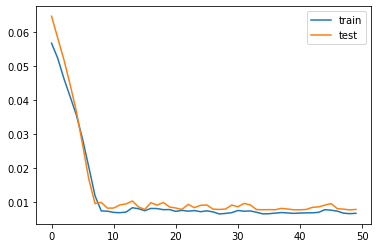

In [874]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=365, validation_data=(test_X, test_y), verbose=1, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [875]:
# make a prediction
yhat = model.predict(test_X)

In [876]:
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

In [877]:
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

In [878]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [879]:
r2_LSTM = r2_score(inv_y, inv_yhat)
print(r2_LSTM)

0.9831259621535858


In [880]:
mae_LSTM = mean_absolute_error(inv_y, inv_yhat)
print(f'MEAN ABSOLUTE ERROR: {mae_LSTM:,.0f} CFS')

MEAN ABSOLUTE ERROR: 59 CFS


In [881]:
df = pd.DataFrame({'Actual CFS':inv_y, 'Predicted CFS':inv_yhat})

fig = go.Figure()
fig.add_trace(go.Scatter(y=df['Actual CFS'],
                    mode='lines',
                    name='Actual CFS'))
fig.add_trace(go.Scatter(y=df['Predicted CFS'],
                    mode='lines',
                    name='Predicted CFS'))

fig.show()

In [882]:
df = pd.DataFrame({'Date':banner_df['DATE'][-len(y_test):], 'Actual CFS':y_test, 'Predicted CFS':y_pred})

fig = go.Figure()
fig.add_trace(go.Scatter(x=df['Date'],y=df['Actual CFS'],
                    mode='lines',
                    name='Actual CFS'))
fig.add_trace(go.Scatter(x=df['Date'],y=df['Predicted CFS'],
                    mode='lines',
                    name='Predicted CFS'))

fig.show()

In [883]:
different_model_mae = {'Model Type': ['Baseline', '1 feature', '2 features','8 features','random forest', 'LSTM'], 
                       'MAE': [mae_baseline, mae_one_feature, mae_two_features, mae_eight_features, mae_random_forest, mae_LSTM], 
                       'R^2':[r2_baseline, r2_one_feature, r2_two_features, r2_eight_features, r2_random_forest, r2_LSTM]}

In [884]:
mae_df = pd.DataFrame(different_model_mae)

In [885]:
mae_df

,Model Type,MAE,R^2
0,Baseline,712.227827,-0.030308
1,1 feature,684.879582,-0.013161
2,2 features,646.533264,0.102225
3,8 features,620.477910,0.153361
4,random forest,311.494240,0.678221
5,LSTM,58.854744,0.983126


The LSTM model crushes it!

In [886]:
px.line(mae_df, x='Model Type', y='R^2')

## Export the model so I can deploy on Heroku


In [887]:
# from joblib import dump
# dump(model, 'model.joblib', compress=True)

In [888]:
## to do:
'''
incorporate nested cross validation (used for time series data)

------

ingest more data:
-1+ more stations from in the basin
-satellite imagery from Google Earth Engine (but would have to get daily imagery- tough?)
- or get it from Planet. Weekly imagery might have to do. Compress to low-res if possible

'''

'\nincorporate nested cross validation (used for time series data)\n\n------\n\ningest more data:\n-1+ more stations from in the basin\n-satellite imagery from Google Earth Engine (but would have to get daily imagery- tough?)\n- or get it from Planet. Weekly imagery might have to do. Compress to low-res if possible\n\n'